In [57]:
import pandas as pd
import numpy as np

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")


In [4]:
result_dir = "/dgx1nas1/storage/data/sam/results/Run3"
feature_type = "_normalized_feature_selected"
plate = "2023_05_30_B1A1R1"

In [13]:
# Path to feature importance .csv
protein_ctrl_feat = (
    f"{result_dir}/{plate}_protein_control_feat_importance{feature_type}.csv"
)
non_protein_ctrl_feat = (
    f"{result_dir}/{plate}_non_protein_control_feat_importance{feature_type}.csv"
)

protein_result_feat = (
    f"{result_dir}/{plate}_protein_feat_importance{feature_type}.csv"
)
non_protein_result_feat = (
    f"{result_dir}/{plate}_non_protein_feat_importance{feature_type}.csv"
)

# Path to F1 scores .csv
protein_ctrl_pred = (
    f"{result_dir}/{plate}_protein_control_f1score{feature_type}.csv"
)
non_protein_ctrl_pred = (
    f"{result_dir}/{plate}_non_protein_control_f1score{feature_type}.csv"
)
protein_var_pred = (
    f"{result_dir}/{plate}_protein_f1score{feature_type}.csv"
)
non_protein_var_pred = (
    f"{result_dir}/{plate}_non_protein_f1score{feature_type}.csv"
)

In [14]:
df_feat_ctrl_protein = pd.read_csv(protein_ctrl_feat)
df_feat_ctrl_non_protein = pd.read_csv(non_protein_ctrl_feat)

df_feat_result_protein = pd.read_csv(protein_result_feat)
df_feat_result_non_protein = pd.read_csv(non_protein_result_feat)

df_pred_ctrl_protein = pd.read_csv(protein_ctrl_pred)
df_pred_ctrl_non_protein = pd.read_csv(non_protein_ctrl_pred)

df_pred_result_protein = pd.read_csv(protein_var_pred)
df_pred_result_non_protein = pd.read_csv(non_protein_var_pred)

In [77]:
# Computes the rank of feature importance weighted by F1 Score
def compute_feature_rank(df_feat, weight, meta_col=['Gene', 'Variant'], output_path=None):
    d = {}
    df_rank = df_feat.rank(axis=1, numeric_only=True)
    for col in df_rank.columns:
        if col in meta_col: continue
        d[col] = np.ma.average(df_rank[col], weights=weight)
    df_avg_rank = pd.DataFrame(d.items(), columns=['feature', 'rank'])
    df_avg_rank.sort_values(by=['rank'], ascending=False, ignore_index=True, inplace=True)
    if not (output_path is None):
        df_avg_rank.to_csv(output_path, index=False)
    else: return df_avg_rank

In [78]:
# Control protein features
compute_feature_rank(df_feat_ctrl_protein, 
                     df_pred_ctrl_protein['F1_Score'], 
                     output_path=f'{result_dir}/ctrl_protein_feat_rank.csv')
# Control non-protein features
compute_feature_rank(df_feat_ctrl_non_protein, 
                     df_pred_ctrl_non_protein['F1_Score'], 
                     output_path=f'{result_dir}/ctrl_non_protein_feat_rank.csv')
# Variants protein features
compute_feature_rank(df_feat_result_protein, 
                     df_pred_result_protein['F1_Score'], 
                     output_path=f'{result_dir}/protein_feat_rank.csv')
# Variants non-protein features
compute_feature_rank(df_feat_result_non_protein, 
                     df_pred_result_non_protein['F1_Score'], 
                     output_path=f'{result_dir}/non_protein_feat_rank.csv')

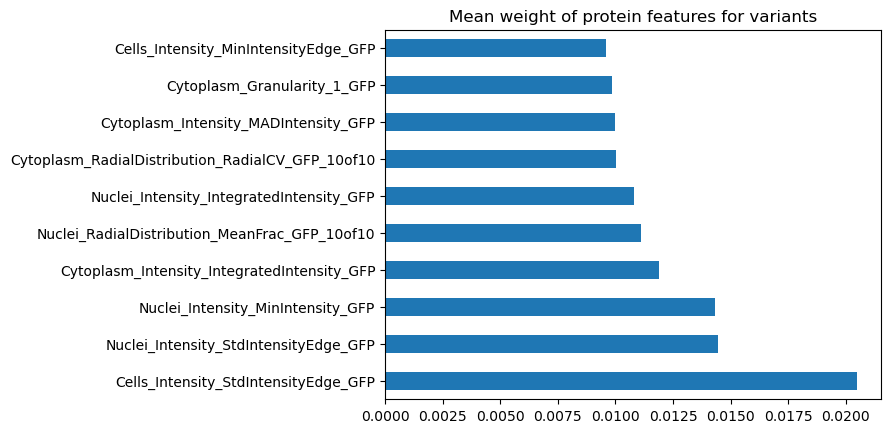

In [8]:
df_feat_result_protein.iloc[:, 2:].astype("float").median(axis=0).nlargest(
    10
).plot(kind="barh")
plt.title("Mean weight of protein features for variants")

plt.show()

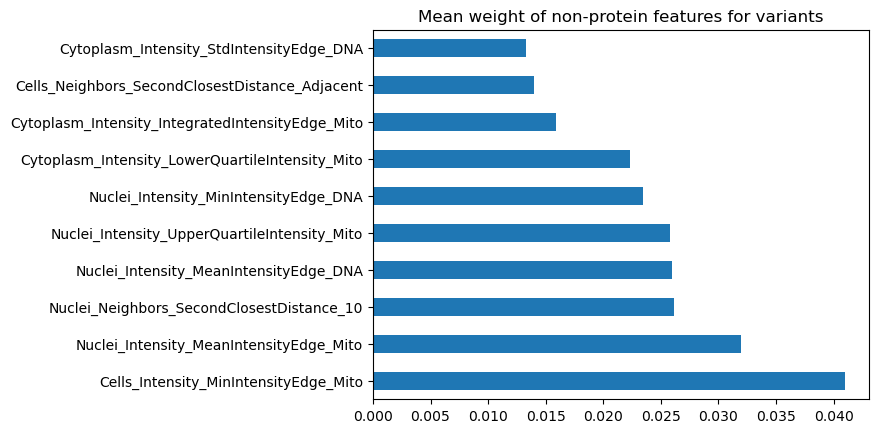

In [9]:
df_feat_result_non_protein.iloc[:, 2:].astype("float").mean(axis=0).nlargest(
    10
).plot(kind="barh")
plt.title("Mean weight of non-protein features for variants")

plt.show()

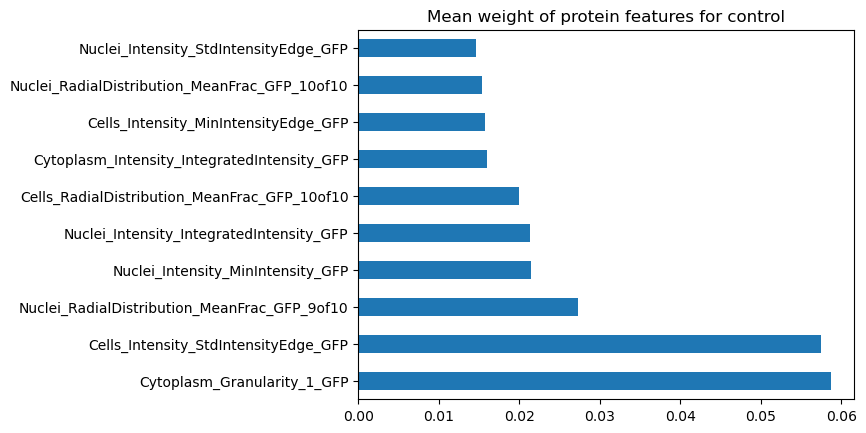

In [10]:
df_feat_ctrl_protein.iloc[:, 2:].astype("float").mean(axis=0).nlargest(
    10
).plot(kind="barh")
plt.title("Mean weight of protein features for control")
plt.show()

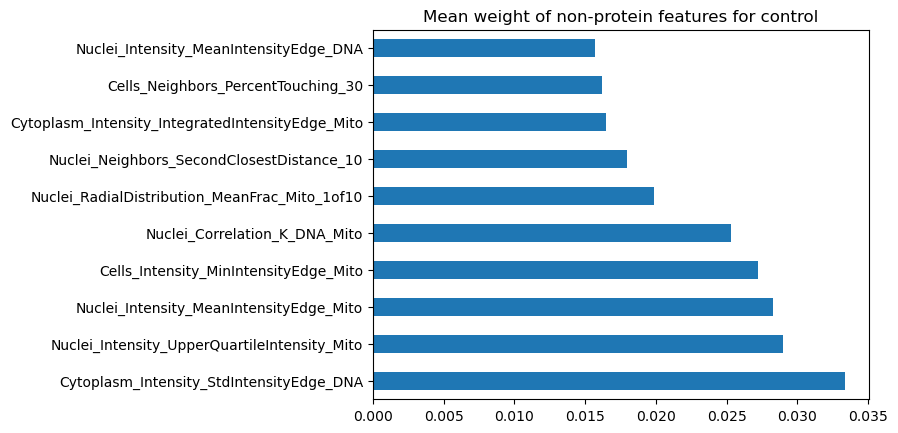

In [11]:
df_feat_ctrl_non_protein.iloc[:, 2:].astype("float").mean(axis=0).nlargest(
    10
).plot(kind="barh")
plt.title("Mean weight of non-protein features for control")
plt.show()

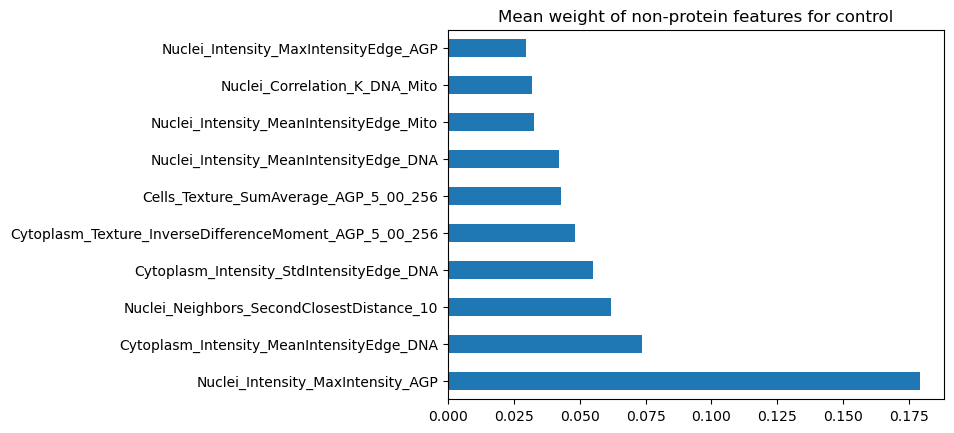

In [31]:
df_feat_ctrl_non_protein[df_feat_ctrl_non_protein["Gene"] == "516 - TC"].iloc[
    :, 2:
].astype("float").mean(axis=0).nlargest(10).plot(kind="barh")
plt.title("Mean weight of non-protein features for control")
plt.show()

In [36]:
result_list = [df_feat_ctrl_protein, df_feat_ctrl_non_protein, df_feat_result_protein, df_feat_result_non_protein]
suffix_list = ['_ctrl_protein', '_ctrl_non_protein', '_result_protein', '_result_non_protein']

In [ ]:
neg_con = ['527 MAPK9', '527 PRKACB', '527 RHEB', '527 SLIRP']

In [53]:
N = 1
output_dir = result_dir + 'top_feature_freq/'
os.makedirs(output_dir, exist_ok=True)
count_list = []
for j in range(len(result_list)):
    df_feat_result = result_list[j]
    df_feat_result = df_feat_result[df_feat_result['Gene'].isin(neg_con)]
    var_dict = {}
    for i, row in df_feat_result.iterrows():
        top_list = list(row.iloc[2:].astype("float").nlargest(N).index)
        for feat in top_list:
            if feat in var_dict.keys():
                var_dict[feat] = var_dict[feat] + 1
            else:
                var_dict[feat] = 1
    df_var_count = pd.DataFrame(var_dict.items(), columns=['Feature', 'Frequency'])
    df_var_count = df_var_count.sort_values(by=['Frequency'], ascending=False).reset_index(drop=True)
    count_list.append(df_var_count)
    # df_var_count.to_csv(f"{output_dir}var_feat_count{suffix_list[j]}.csv", index=False)


In [57]:
count_list[1].iloc[:10]

Feature  Frequency
0               Cytoplasm_Intensity_MADIntensity_AGP          9
1              Cells_Texture_SumAverage_AGP_5_00_256          3
2                  Cells_Correlation_Costes_Mito_AGP          2
3                   Cells_Correlation_Costes_AGP_DNA          2
4              Cells_Intensity_MeanIntensityEdge_AGP          2
5  Cytoplasm_Texture_InverseDifferenceMoment_AGP_...          2
6  Cytoplasm_Texture_InverseDifferenceMoment_AGP_...          1
7  Cytoplasm_Texture_AngularSecondMoment_AGP_20_0...          1
8                  Nuclei_Correlation_Costes_AGP_DNA          1
9  Cells_Texture_InverseDifferenceMoment_AGP_5_00...          1

In [51]:
df_feat_ctrl_protein['Gene'].unique()

array(['516 - TC', '527 ALK R1275Q', '527 ALK wt', '527 MAPK9',
       '527 PRKACB', '527 RHEB', '527 SLIRP', 'PTK2B'], dtype=object)